In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    plt.figure(figsize=(10, 6))
    if type(y) is tuple:
        for y_curr in y:
            plt.plot(x[start:end], y_curr[start:end], format)
    else:
        plt.plot(x[start:end], y[start:end], format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
        plt.legend(legend)
    plt.title(title)
    plt.grid(True)
    plt.show()

In [4]:
x = np.array(np.arange(0.0, 30, 0.1))
y = []
for value in x:
    y.append(math.sin(value))

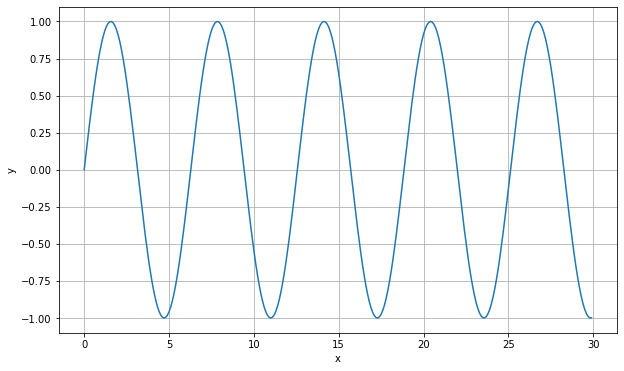

In [5]:
time = np.array(x)
series = np.array(y)
plot_series(time, series, xlabel='x', ylabel='y')

In [6]:
split_time = 150

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [9]:
# tweaking
window_size = 3
batch_size = 8
shuffle_buffer_size = 10

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [10]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 64)             256       
                                                                 
 lstm (LSTM)                 (None, 3, 64)             33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 66,369
Trainable params: 66,369
Non-trainable params: 0
_________________________________________________________________


In [11]:
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [12]:
history = model.fit(train_set,epochs=10)

Epoch 1/10
19/19 [==============================] - 3s 13ms/step - loss: 0.2238 - mae: 0.6071
Epoch 2/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0774 - mae: 0.3316
Epoch 3/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0223 - mae: 0.1871
Epoch 4/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0167 - mae: 0.1617
Epoch 5/10
19/19 [==============================] - 0s 5ms/step - loss: 0.0153 - mae: 0.1567
Epoch 6/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0148 - mae: 0.1529
Epoch 7/10
19/19 [==============================] - 0s 5ms/step - loss: 0.0146 - mae: 0.1532
Epoch 8/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0144 - mae: 0.1516
Epoch 9/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0143 - mae: 0.1516
Epoch 10/10
19/19 [==============================] - 0s 5ms/step - loss: 0.0142 - mae: 0.1506


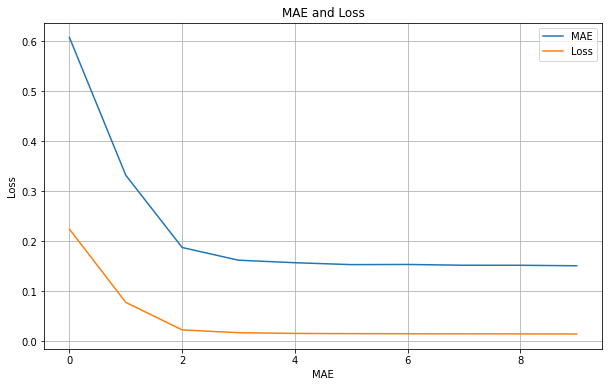

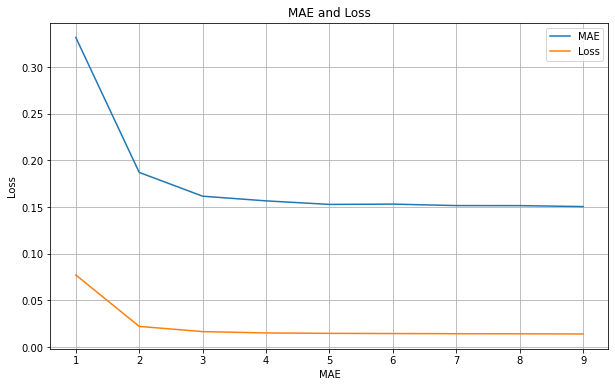

In [13]:
mae=history.history['mae']
loss=history.history['loss']
epochs=range(len(loss)) 
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Model Prediction

In [14]:
def model_forecast(model, series, window_size, batch_size):

    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    
    return forecast

19/19 [==============================] - 1s 2ms/step


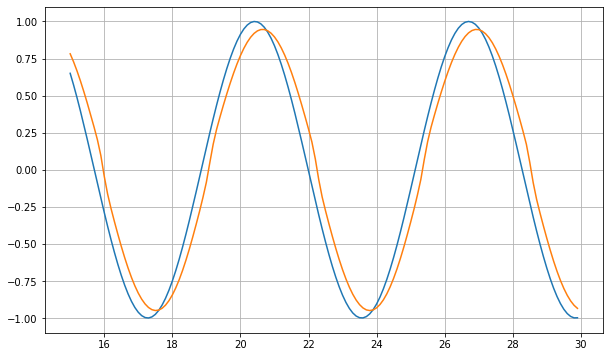

In [15]:
forecast_series = series[split_time-window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()
plot_series(time_valid, (x_valid, results))

In [16]:
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

0.15509585
